<a href="https://colab.research.google.com/github/noahgift/cloud-data-analysis-at-scale/blob/master/GPU_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPU Demos

### Install and Imports

Do a `pip install` of the [numba](https://numba.pydata.org/) library and check for where the cuda `.so` files are kept.  If a `.so` appears CUDA is likely installed.

In [1]:
!pip install numba
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-10.1/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so


Install libraries

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from pylab import imshow, show
from timeit import default_timer as timer

### Mandelbrot

##### Non-GPU Mandelbrot

In [0]:
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

In [0]:
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

Mandelbrot created in 4.805243 s


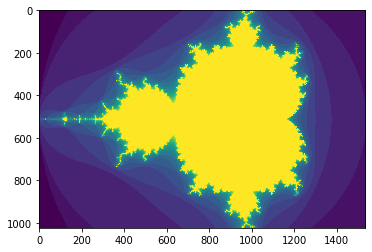

In [9]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()

##### Numba Mandelbrot

Numba is [LLVM JIT](http://numba.pydata.org/) support for Python

###### Run Numba Mandelbrot

In [0]:
@jit
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

Mandelbrot created in 0.421521 s


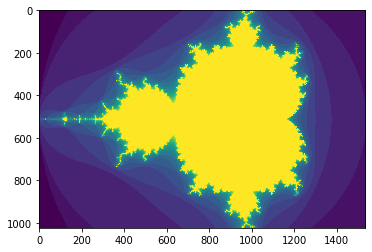

In [12]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()

##### CUDA GPU Mandelbrot

In [0]:
mandel_gpu = cuda.jit(restype=uint32, argtypes=[f8, f8, uint32], device=True)(mandel)

In [0]:
@cuda.jit(argtypes=[f8, f8, f8, f8, uint8[:,:], uint32])
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)

Mandelbrot created in 0.344193 s


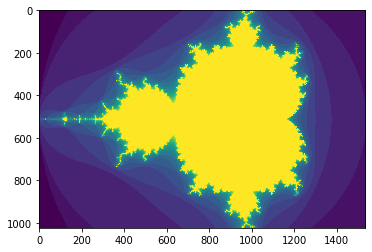

In [0]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()

##### Cuda Vectorize

In [6]:
from numba import (cuda, vectorize)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from functools import wraps
from time import time

def real_estate_df():
    """30 Years of Housing Prices"""

    df = pd.read_csv("https://raw.githubusercontent.com/noahgift/real_estate_ml/master/data/Zip_Zhvi_SingleFamilyResidence.csv")
    df.rename(columns={"RegionName":"ZipCode"}, inplace=True)
    df["ZipCode"]=df["ZipCode"].map(lambda x: "{:.0f}".format(x))
    df["RegionID"]=df["RegionID"].map(lambda x: "{:.0f}".format(x))
    return df

def numerical_real_estate_array(df):
    """Converts df to numpy numerical array"""

    columns_to_drop = ['RegionID', 'ZipCode', 'City', 'State', 'Metro', 'CountyName']
    df_numerical = df.dropna()
    df_numerical = df_numerical.drop(columns_to_drop, axis=1)
    return df_numerical.values

def real_estate_array():
    """Returns Real Estate Array"""

    df = real_estate_df()
    rea = numerical_real_estate_array(df)
    return np.float32(rea)


@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

def cuda_operation():
    """Performs Vectorized Operations on GPU"""

    x = real_estate_array()
    y = real_estate_array()

    print("Moving calculations to GPU memory")
    x_device = cuda.to_device(x)
    y_device = cuda.to_device(y)
    out_device = cuda.device_array(
        shape=(x_device.shape[0],x_device.shape[1]), dtype=np.float32)
    print(x_device)
    print(x_device.shape)
    print(x_device.dtype)

    print("Calculating on GPU")
    add_ufunc(x_device,y_device, out=out_device)

    out_host = out_device.copy_to_host()
    print(f"Calculations from GPU {out_host}")

cuda_operation()

Moving calculations to GPU memory
(10015, 259)
float32
Calculating on GPU
Calculations from GPU [[2.0000e+00 8.4160e+05 8.4700e+05 ... 2.1086e+06 2.0970e+06 2.0888e+06]
 [4.0000e+00 1.0848e+06 1.0934e+06 ... 3.0316e+06 3.0398e+06 3.0506e+06]
 [6.0000e+00 1.4180e+05 1.4240e+05 ... 2.2760e+05 2.2700e+05 2.2660e+05]
 ...
 [3.0554e+04 1.9780e+05 1.9620e+05 ... 4.3960e+05 4.4000e+05 4.4080e+05]
 [3.0560e+04 1.7340e+05 1.7500e+05 ... 3.8140e+05 3.8460e+05 3.8720e+05]
 [3.0562e+04 5.0700e+05 5.0800e+05 ... 1.5672e+06 1.5590e+06 1.5484e+06]]
